# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels
from lib.shared.segment_cellpose import estimate_diameters, segment_cellpose
from lib.shared.segment_microsam import segment_microsam
from lib.shared.segment_stardist import segment_stardist
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.phenotype.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)

2025-03-28 11:59:04.471733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [3]:
# parameters for testing
TEST_PLATE = 2
TEST_WELL = "A1"
TEST_TILE = 1
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["DAPI", "VIMENTIN", "ACTIN", "TUBULIN"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_yellow"]

# parameters for feature extraction
FOCI_CHANNEL = None

Loading test image...
Applying illumination correction...
Example corrected image:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


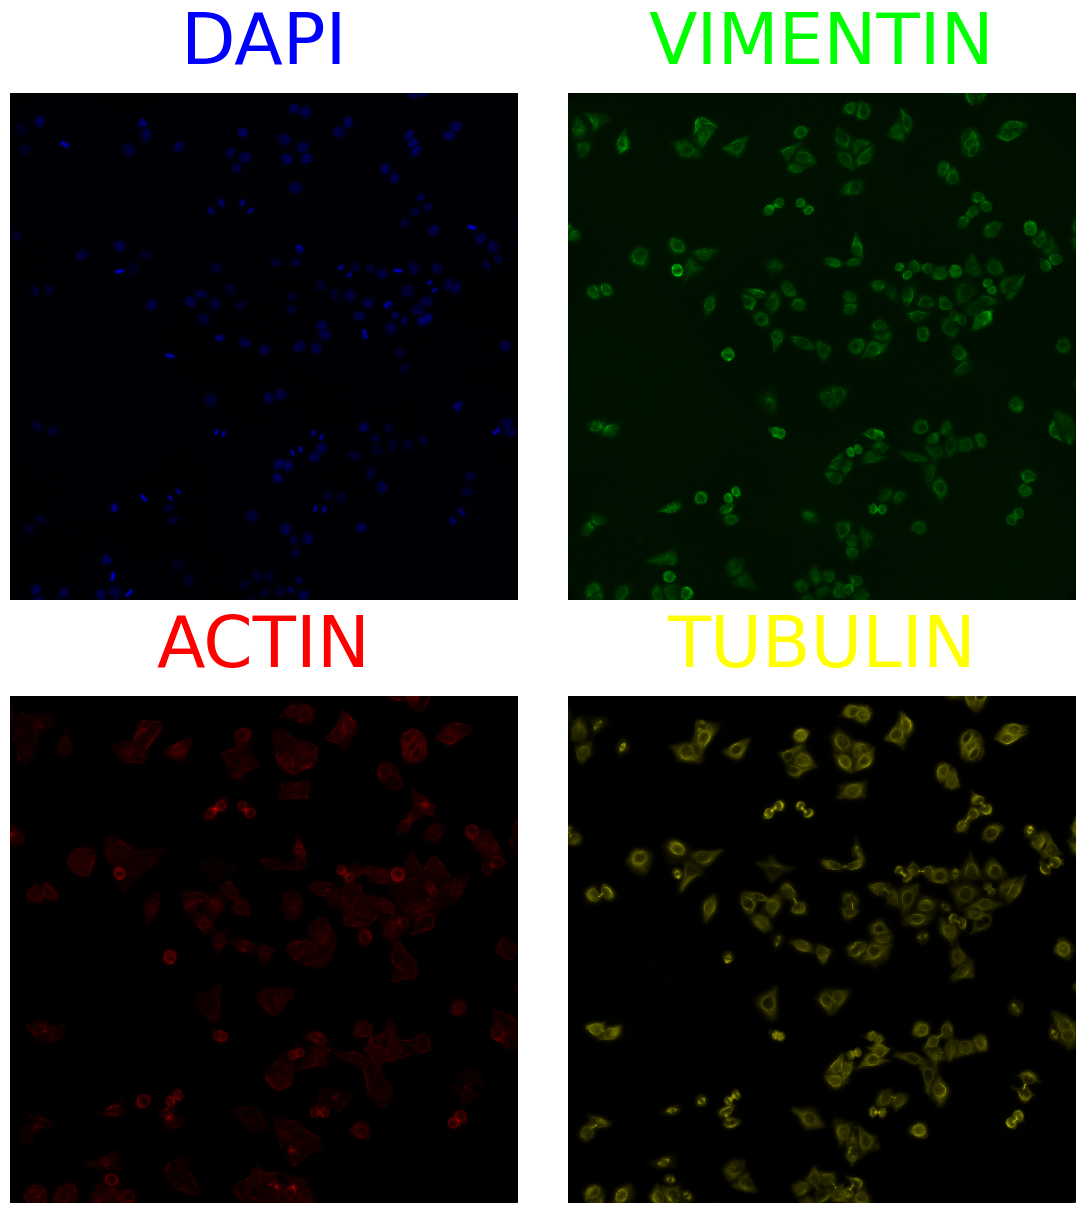

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Index of the channel that other channels will be aligned to.
- `SOURCE`: Index of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.

In [5]:
# Set alignment parameters
ALIGN = None
TARGET = None
SOURCE = None
RIDERS = None
REMOVE_CHANNEL = None

# Derive alignment indexes
if ALIGN:
    TARGET_INDEX = CHANNEL_NAMES.index(TARGET)
    SOURCE_INDEX = CHANNEL_NAMES.index(SOURCE)
    RIDER_INDEXES = [CHANNEL_NAMES.index(r) for r in RIDERS]

In [6]:
if ALIGN:
    print("Aligning channels...")
    aligned_image = align_phenotype_channels(
        corrected_image,
        target=TARGET_INDEX,
        source=SOURCE_INDEX,
        riders=RIDER_INDEXES,
        remove_channel=REMOVE_CHANNEL,
    )
else:
    aligned_image = corrected_image

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Common Parameters
- `CYTO_CHANNEL`: Channel to use for cell detection (typically "PHALLOIDIN")
- `GPU`: Set to True to use GPU acceleration (if available)
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing)

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".
- `POINTS_PER_SIDE`: Number of points to sample along each side of the image. Default is 32.
- `POINTS_PER_BATCH`: Number of points to process in one batch. Default is 16.
- `STABILITY_SCORE_THRESH`: Threshold for stability score. Default is 0.95.
- `PRED_IOU_THRESH`: Threshold for predicted IoU. Default is 0.88.

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `PROB_THRESH`: Probability threshold for segmentation. Default is 0.479071.
- `NMS_THRESH`: Non-maximum suppression threshold. Default is 0.3.

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [35]:
# Common parameters
CYTO_CHANNEL = "TUBULIN"
GPU = False
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    FLOW_THRESHOLD = 0.4
    CELLPROB_THRESHOLD = 0

    print("Estimating optimal cell and nuclei diameters...")
    # NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
    #     aligned_image,
    #     dapi_index=DAPI_INDEX,
    #     cyto_index=CYTO_INDEX,
    #     cyto_model=CELLPOSE_MODEL,
    # )
    NUCLEI_DIAMETER = 44.3
    CELL_DIAMETER = 160

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"
    POINTS_PER_SIDE = 32
    POINTS_PER_BATCH = 16
    STABILITY_SCORE_THRESH = 0.95
    PRED_IOU_THRESH = 0.88

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    PROB_THRESH = 0.479071
    NMS_THRESH = 0.3

Estimating optimal cell and nuclei diameters...


Segmenting image with cellpose...


INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [3, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 43.19 sec
INFO:cellpose.models:channels set to [2, 3]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 84.35 sec
found 174 nuclei before removing edges
found 165 cells before removing edges


removing edges


found 168 nuclei before reconciling
found 145 cells before reconciling


reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 1 nuclei: 134
Cells with 2 nuclei: 11
--------------------------



found 145 nuclei/cells after reconciling


Number of nuclei segmented: 145
Number of cells segmented: 145
Example microplots for DAPI channel and nuclei segmentation:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


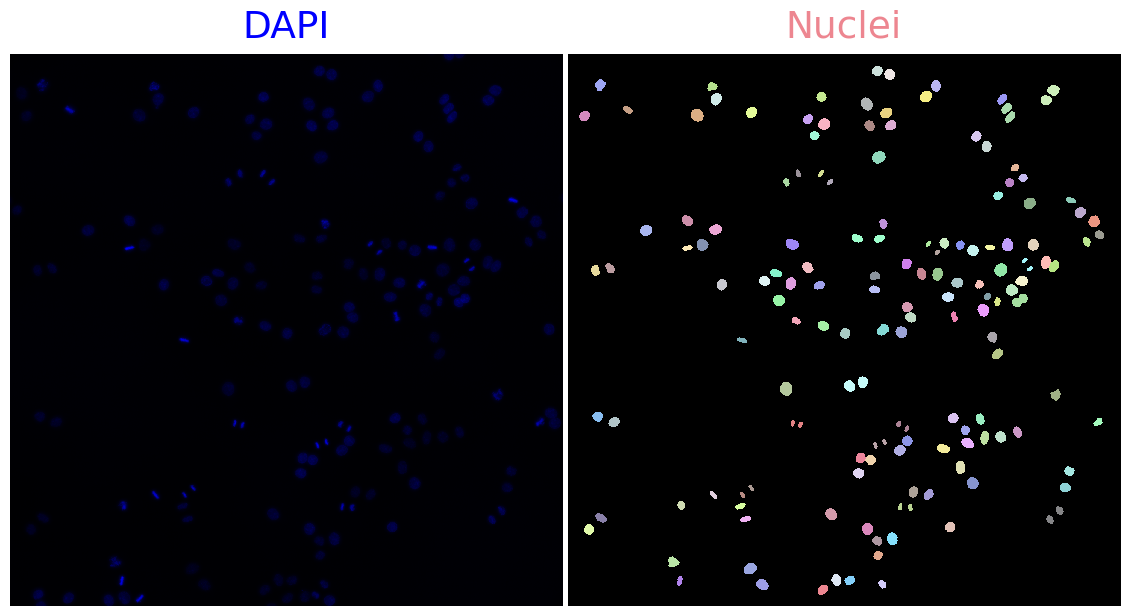

Example microplots for merged channels and cells segmentation:


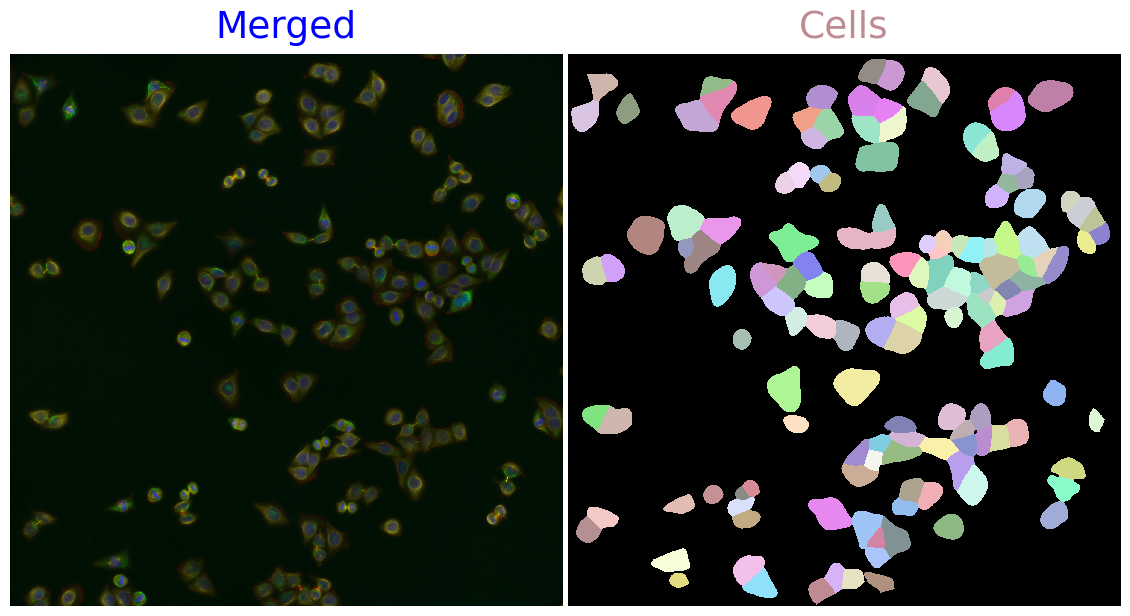

Example microplot for phenotype data annotated with segmentation:


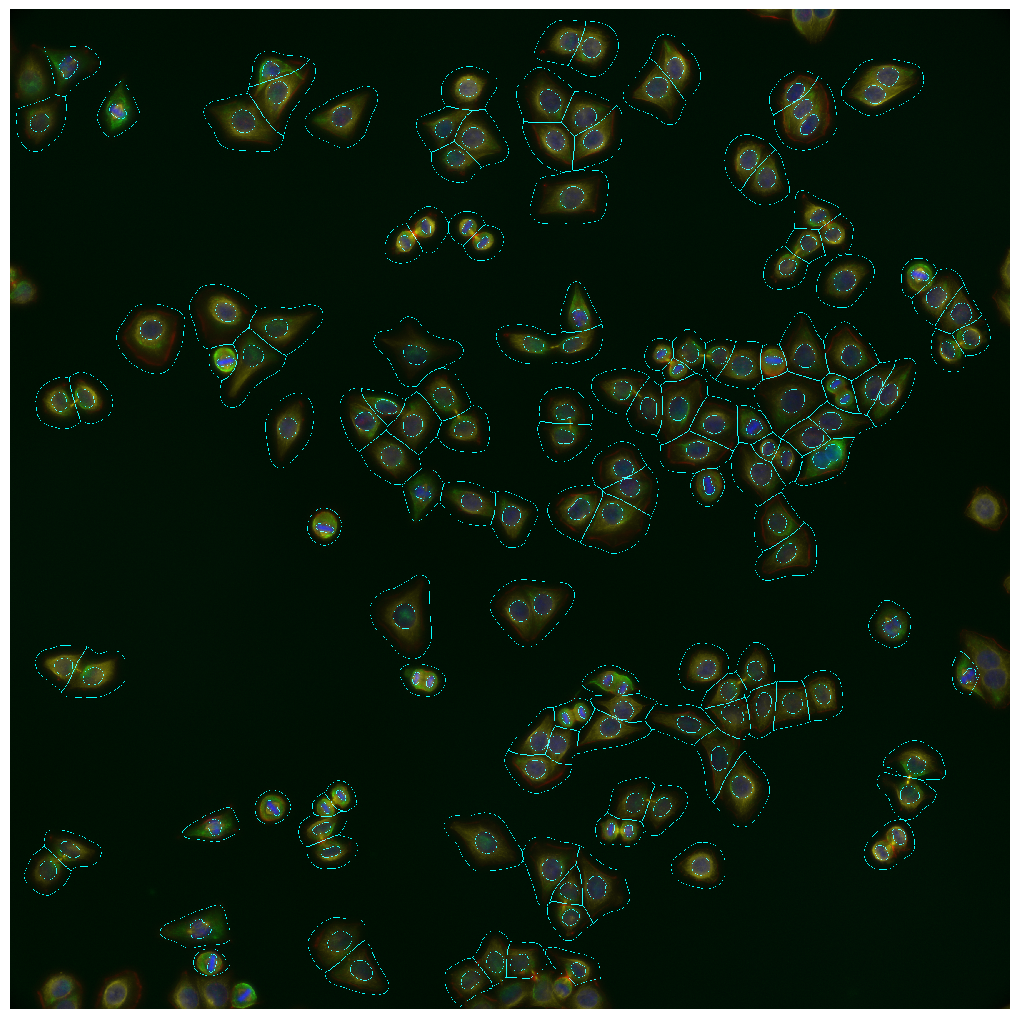

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 145


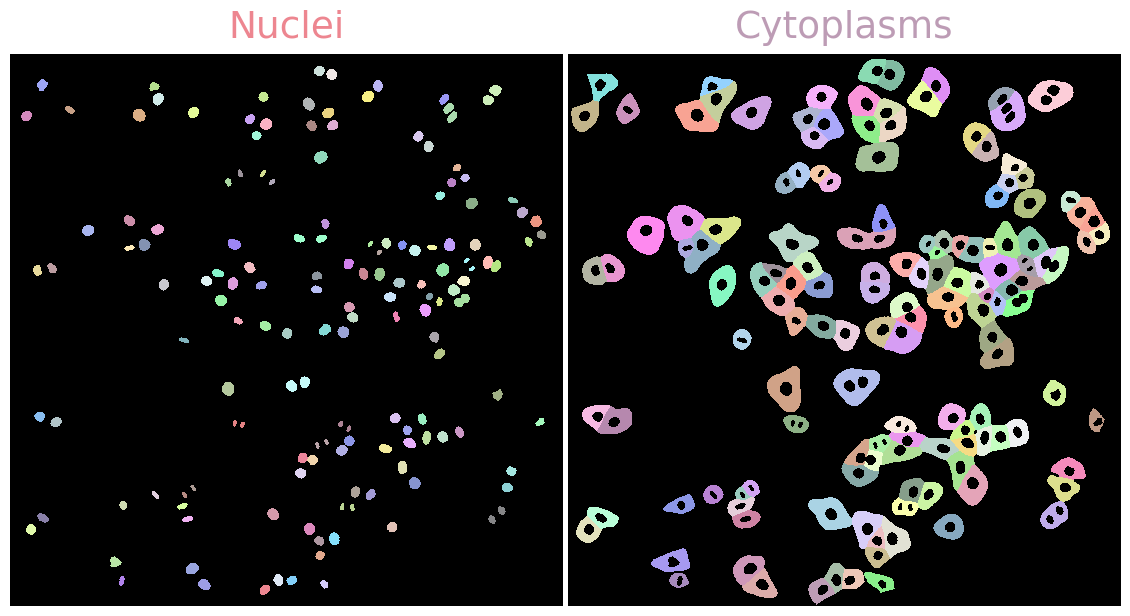

In [36]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    nuclei, cells = segment_cellpose(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            flow_threshold=FLOW_THRESHOLD,
            cellprob_threshold=CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "microsam":
    nuclei, cells = segment_microsam(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        microsam_kwargs=dict(
            points_per_side=POINTS_PER_SIDE,
            points_per_batch=POINTS_PER_BATCH,
            stability_score_thresh=STABILITY_SCORE_THRESH,
            pred_iou_thresh=PRED_IOU_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    nuclei, cells = segment_stardist(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            prob_thresh=PROB_THRESH,
            nms_thresh=NMS_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS[0:4],
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS[0:4] + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

In [37]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    aligned_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

Extracting phenotype features:


,label,nucleus_DAPI_int,nucleus_VIMENTIN_int,nucleus_ACTIN_int,nucleus_TUBULIN_int,nucleus_DAPI_mean,nucleus_VIMENTIN_mean,nucleus_ACTIN_mean,nucleus_TUBULIN_mean,nucleus_DAPI_std,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,19363657,5939476,8580998,10250998,11901.448679,3650.569146,5274.122926,6300.551936,1768.711917,...,1,0.324034,87.083110,138.370817,93.609351,1,0.233025,93.494471,135.803488,93.703084
1,2,20890090,5705693,9952695,13283349,11696.578947,3194.676932,5572.617581,7437.485442,1512.550348,...,1,0.299010,87.083110,149.846145,94.266329,1,0.215407,93.494471,144.989896,92.865222
2,3,21922037,5285528,13581319,13433031,12775.079837,3080.144522,7914.521562,7828.106643,1985.818483,...,1,0.347979,89.768738,198.633091,63.875250,1,0.259162,94.591919,197.068927,63.990112
3,4,21042481,6228146,8683649,8485965,12276.826721,3633.690782,5066.306301,4950.971412,3707.064724,...,1,0.062257,152.916288,155.198446,74.260825,1,0.043896,153.347068,154.279612,74.143849
4,5,19260370,5505560,7866537,6492978,15557.649435,4447.140549,6354.230210,5244.731826,3486.922961,...,1,0.460870,72.412906,161.378345,45.087484,1,0.331250,75.214701,165.298329,44.853349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,141,11416419,5440726,4582156,7293608,5676.986077,2705.482844,2278.545997,3626.856290,1017.077138,...,1,0.309859,95.553311,256.545757,132.474684,1,0.226221,97.352359,255.205420,132.556442
141,142,9594471,4464933,7179282,6282468,6469.636548,3010.743763,4841.053270,4236.323668,1228.661864,...,2,0.277778,75.564584,119.035309,179.139122,2,0.187166,80.294956,114.457726,178.031825
142,143,9194524,2910959,3735125,4816922,9637.865828,3051.319706,3915.225367,5049.184486,1796.389284,...,1,0.011111,110.288539,119.035309,76.829099,1,0.008278,107.536953,114.457726,76.578071
143,144,19726824,3468054,4094690,4380257,25226.117647,4434.851662,5236.176471,5601.351662,10687.351793,...,0,0.000000,85.736202,304.101791,98.232793,0,0.000000,85.544722,302.759970,97.759023


In [38]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',
 'cell_j',
 'cell_lower_quartile',
 'c

## Add phenotype process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [39]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "method": SEGMENTATION_METHOD,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "mode": None,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "flow_threshold": FLOW_THRESHOLD,
        "cellprob_threshold": CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["phenotype"].update({
        "microsam_model": MICROSAM_MODEL,
        "points_per_side": POINTS_PER_SIDE,
        "points_per_batch": POINTS_PER_BATCH,
        "stability_score_thresh": STABILITY_SCORE_THRESH,
        "pred_iou_thresh": PRED_IOU_THRESH,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update({
        "stardist_model": STARDIST_MODEL,
        "prob_thresh": PROB_THRESH,
        "nms_thresh": NMS_THRESH,
    })

if ALIGN:  # then add the source index, rider indexes, and remove index
    config["phenotype"]["target"] = TARGET_INDEX
    config["phenotype"]["source"] = SOURCE_INDEX
    config["phenotype"]["riders"] = RIDER_INDEXES
    config["phenotype"]["remove_channel"] = REMOVE_CHANNEL

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)